In [0]:
#Librerias usadas en la prueba
import pandas as pd
import numpy as np
from pandas import datetime
from matplotlib import pyplot as plt
from matplotlib import pyplot
import os

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from math import sqrt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

In [32]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
totalhouses=pd.read_csv('gdrive/My Drive/Colab Notebooks/Proyecto/halfhourly_dataset/totalhouses.csv', parse_dates=['tstp'], index_col="tstp")

In [34]:
totalhouses.head()

,house1,house2,house3,house4,house5,house6,house7,house8,house9,house10,house11,consumo_agregado
tstp,,,,,,,,,,,,
2011-11-23 13:30:00,0.110,0.075,0.055,0.938,0.201,0.049,0.01,0.250,0.176,0.151,0.458,2.473
2011-11-23 14:00:00,0.244,0.064,0.144,1.650,0.185,0.048,0.00,0.163,0.092,0.059,0.534,3.183
2011-11-23 14:30:00,0.241,0.318,0.106,0.752,0.248,0.048,0.00,0.177,0.093,0.088,0.353,2.424
2011-11-23 15:00:00,0.287,0.185,0.116,0.713,0.486,0.049,0.00,0.162,0.158,0.086,0.242,2.484
2011-11-23 15:30:00,0.296,0.121,0.139,0.261,0.281,0.048,0.00,0.162,0.142,0.116,0.324,1.890


In [35]:
totalhouses.tail()

,house1,house2,house3,house4,house5,house6,house7,house8,house9,house10,house11,consumo_agregado
tstp,,,,,,,,,,,,
2014-02-27 22:00:00,0.456,0.631,0.243,0.567,0.184,0.145,0.072,0.192,0.154,0.097,0.396,3.137
2014-02-27 22:30:00,0.354,0.178,0.171,0.695,0.327,0.139,0.083,0.166,0.168,0.065,0.264,2.610
2014-02-27 23:00:00,0.263,0.108,0.132,0.807,0.163,0.141,0.051,0.171,0.142,0.026,0.264,2.268
2014-02-27 23:30:00,0.298,0.078,0.126,0.308,0.122,0.139,0.000,0.168,0.033,0.024,0.330,1.626
2014-02-28 00:00:00,0.218,0.113,0.123,2.249,0.167,0.141,0.000,0.161,0.048,0.026,0.213,3.459


In [36]:
len(totalhouses)

39665

In [0]:
df1=totalhouses[['consumo_agregado']]

In [38]:
#Dataset usado para la prueba
df1.head()

,consumo_agregado
tstp,
2011-11-23 13:30:00,2.473
2011-11-23 14:00:00,3.183
2011-11-23 14:30:00,2.424
2011-11-23 15:00:00,2.484
2011-11-23 15:30:00,1.890


In [39]:
df1.dtypes

consumo_agregado    float64
dtype: object

In [0]:
# Variables de Configuración 
batch_size_exp = 1
epoch_exp = 7
neurons_exp = 10
#Se predice 1 semana(168 horas) horas pero como la resolución es de media hora entonces se predice 336
predict_values_exp = 336
lag_exp=24

In [0]:
# Función que convierte la trama a un problema de aprendizaje supervisado
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [0]:
# Función que crea una serie diferenciada
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [0]:
# Función que invierte la diferenciaciòn 
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [0]:
# Función que escala los datos [0, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(train)
    # Transformación del Train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # Transformación del test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [0]:
# Función que invierte escala los datos [0, 1]
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, 1]

In [0]:
# Ajuste de los datos en el modelo LSTM Deep Learning
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    return model

In [0]:
# hace una predicción one-step
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    #print(X)
    yhat = model.predict(X, batch_size=1)
    return yhat[0,0]

In [0]:
# transformar datos a estacionarios
raw_values = df1.values
diff_values = difference(raw_values, 1)

In [49]:
raw_values

array([[2.473    ],
       [3.183    ],
       [2.424    ],
       ...,
       [2.268    ],
       [1.626    ],
       [3.4590001]])

In [0]:
#diff_values.plot()

In [0]:
# transformar datos a un aprendizaje supervisado
supervised = timeseries_to_supervised(diff_values, lag_exp)
supervised_values = supervised.values

In [52]:
supervised_values[100]

array([array([-0.031]), array([0.06]), array([-0.1]), array([0.152]),
       array([-0.577]), array([0.773]), array([-0.209]), array([-0.082]),
       array([0.144]), array([-0.052]), array([-0.245]), array([0.001]),
       array([-0.247]), array([0.38]), array([-0.496]), array([0.01]),
       array([0.23]), array([0.043]), array([-0.108]), array([0.459]),
       array([-0.071]), array([-0.085]), array([-0.531]),
       array([-1.0459999]), array([-0.01])], dtype=object)

In [53]:
len(supervised_values)

39664

In [0]:
# Dividen los datos en train y test
train, test = supervised_values[0:-predict_values_exp], supervised_values[-predict_values_exp:]

In [55]:
train[5]

array([array([-0.266]), array([-0.594]), array([0.06]), array([-0.759]),
       array([0.71]), 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, array([0.948])], dtype=object)

In [56]:
test[5]

array([array([-1.134]), array([-0.0509999]), array([0.317]),
       array([-0.403]), array([-0.1910001]), array([1.961]),
       array([-0.838]), array([-0.094]), array([-0.319]), array([0.27]),
       array([-0.256]), array([-0.46]), array([0.635]), array([-0.7]),
       array([0.76]), array([0.642]), array([-0.782]), array([-0.244]),
       array([1.142]), array([-0.025]), array([0.344]), array([-0.269]),
       array([-0.635]), array([0.154]), array([-1.018])], dtype=object)

In [0]:
# Se transforman los datos a una escala de [0,1]
scaler, train_scaled, test_scaled = scale(train, test)

In [58]:
train_scaled[5]

array([0.51136515, 0.46776552, 0.55469892, 0.44583278, 0.64110063,
       0.54672338, 0.54672338, 0.54672338, 0.54672338, 0.54672338,
       0.54672338, 0.54672338, 0.54672338, 0.54672338, 0.54672338,
       0.54672338, 0.54672338, 0.54672338, 0.54672338, 0.54672338,
       0.54672338, 0.54672338, 0.54672338, 0.54672338, 0.67273694])

In [59]:
train_scaled.shape

(39328, 25)

In [60]:
test_scaled.shape

(336, 25)

In [61]:
# Entrenar el modelo
lstm_model = fit_lstm(train_scaled, batch_size_exp, epoch_exp, neurons_exp)

W0709 23:54:12.638168 140486458881920 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0709 23:54:12.723726 140486458881920 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0709 23:54:12.762267 140486458881920 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0709 23:54:13.078185 140486458881920 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0709 23:54:13.314813 140486458881920 deprecation.py:323

Epoch 1/1
39328/39328 [==============================] - 68s 2ms/step - loss: 0.0071
Epoch 1/1
39328/39328 [==============================] - 67s 2ms/step - loss: 0.0068
Epoch 1/1
39328/39328 [==============================] - 66s 2ms/step - loss: 0.0067
Epoch 1/1
39328/39328 [==============================] - 66s 2ms/step - loss: 0.0066
Epoch 1/1
39328/39328 [==============================] - 69s 2ms/step - loss: 0.0066
Epoch 1/1
39328/39328 [==============================] - 71s 2ms/step - loss: 0.0066
Epoch 1/1
39328/39328 [==============================] - 72s 2ms/step - loss: 0.0065


In [62]:
test_scaled[1, 0:-1]

array([0.52133456, 0.80739068, 0.43533165, 0.53422837, 0.50432009,
       0.58261332, 0.5126944 , 0.48557756, 0.6311312 , 0.45367539,
       0.64774691, 0.63206168, 0.44277549, 0.51428951, 0.69852453,
       0.54340024, 0.59244982, 0.51096637, 0.46231556, 0.56719394,
       0.68376978, 0.47653861, 0.56732687, 0.49129337])

In [63]:
test_scaled[1, -1]

0.493154326549364

In [64]:
len(test_scaled)

336

In [65]:
len(train)

39328

In [66]:
len(raw_values)

39665

In [67]:
# Test de datos walk-forward validation 
predictions = list()
expectations = list()
test_pred = list()
for i in range(len(test_scaled)):
    # se hace una predicción one-step
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)#batch_size_exp to 1
    
    # Se reemplaza el valor test scaled con el valor predecido.
    test_pred = [yhat] + test_pred 
    if len(test_pred) > lag_exp+1:
        test_pred = test_pred[:-1]
    if i+1<len(test_scaled):
        if i+1 > lag_exp+1:
            test_scaled[i+1] = test_pred
        else:
            test_scaled[i+1] = np.concatenate((test_pred, test_scaled[i+1, i+1:]),axis=0)

    # Se invierte el escalamiento
    yhat = invert_scale(scaler, X, yhat)
    # Se invierte la diferenciación
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # Se almacena la predicción
    expected = raw_values[len(train) + i + 1]
    if expected != 0:
        predictions.append(yhat)
        expectations.append(expected)
    print('Hour=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Hour=1, Predicted=3.702822, Expected=3.796000
Hour=2, Predicted=3.783205, Expected=3.393000
Hour=3, Predicted=3.355390, Expected=3.710000
Hour=4, Predicted=3.682240, Expected=3.659000
Hour=5, Predicted=3.564439, Expected=2.525000
Hour=6, Predicted=2.467407, Expected=1.507000
Hour=7, Predicted=1.434552, Expected=1.398000
Hour=8, Predicted=1.380760, Expected=1.341000
Hour=9, Predicted=1.312485, Expected=1.229000
Hour=10, Predicted=1.267263, Expected=1.333000
Hour=11, Predicted=1.354095, Expected=1.479000
Hour=12, Predicted=1.534038, Expected=1.783000
Hour=13, Predicted=1.821665, Expected=1.469000
Hour=14, Predicted=1.490887, Expected=1.876000
Hour=15, Predicted=1.891510, Expected=1.813000
Hour=16, Predicted=1.851363, Expected=3.625000
Hour=17, Predicted=3.632840, Expected=2.532000
Hour=18, Predicted=2.540068, Expected=1.656000
Hour=19, Predicted=1.651167, Expected=2.544000
Hour=20, Predicted=2.530862, Expected=1.994000
Hour=21, Predicted=2.003294, Expected=2.689000
Hour=22, Predicted=2.6

In [70]:
# Evaluar el desempeño
expectations = np.array(expectations)
predictions = np.array(predictions)
print("Mean Absolute Percent Error: ",(np.mean(np.abs((expectations - predictions) / expectations))*100))

Mean Absolute Percent Error:  21.128958298888723


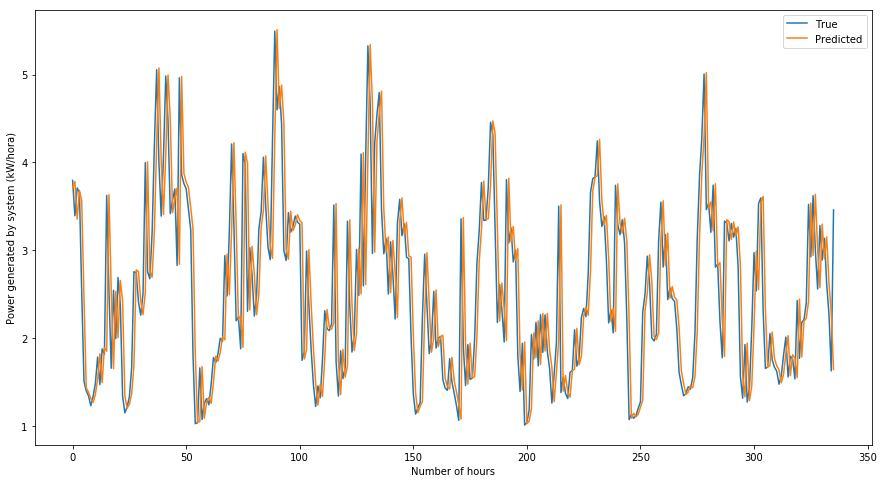

In [71]:
# Plotting valores observados vs predicidos
pyplot.figure(figsize=(15,8))
pyplot.plot(expectations, label="True")
pyplot.plot(predictions, label="Predicted")
pyplot.legend(loc='upper right')
pyplot.xlabel("Number of hours")
pyplot.ylabel("Power generated by system (kW/hora)")
pyplot.show()